In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision # Import for mixed precision


2025-05-23 16:51:55.228913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 16:51:55.386031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747993915.466477   39647 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747993915.491117   39647 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747993915.623405   39647 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
BASE_DATA_DIR = "/media/tairo/Storages/AIProject/AboutModel/TraAI/Data"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")
VALIDATION_DIR = os.path.join(BASE_DATA_DIR, "validation")
TEST_DIR = os.path.join(BASE_DATA_DIR, "test")


In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
VGG16_INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

In [4]:
BATCH_SIZE = 32
EPOCHS = 100
INITIAL_LEARNING_RATE = 0.0001 # Adam usually works well with this LR for transfer learning
REG_STRENGTH = 0.0005

In [5]:
MODEL_SAVE_PATH = "VGG16_TomatoDiseases.keras"

In [6]:
#PERFORMANCE OPTIMIZATIONS
print("Applying Performance Optimizations")
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"Mixed precision policy enabled: {mixed_precision.global_policy().name}")
except Exception as e:
    print(f"Couldn't enable mixed precision: {e}. Continuing with float32.")

Applying Performance Optimizations
Mixed precision policy enabled: mixed_float16


In [7]:
#Data Loading
print("Loading Data (images on disk are 224x224)")
train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH), interpolation='nearest',
    batch_size=None, shuffle=True
)
val_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH), interpolation='nearest',
    batch_size=None, shuffle=False
)
test_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH), interpolation='nearest',
    batch_size=None, shuffle=False
)
class_names = train_dataset_raw.class_names 
num_classes = len(class_names)
print(f"Found classes: {class_names} (Number of classes: {num_classes})")

Loading Data (images on disk are 224x224)
Found 6433 files belonging to 3 classes.


I0000 00:00:1747993922.320167   39647 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1967 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 1840 files belonging to 3 classes.
Found 920 files belonging to 3 classes.
Found classes: ['Bacterial Spot', 'Early Blight', 'Yellow Leaf Curl'] (Number of classes: 3)


In [8]:
#Data Augmentation and Preprocessing Functions
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(factor=0.15),
    tf.keras.layers.RandomContrast(factor=0.15),
], name="data_augmentation")

def preprocess_data_vgg16(image, label, is_training):
    if is_training:
        image = data_augmentation_layers(image, training=True)
    image = tf.cast(image, tf.float32)
    image = vgg16_preprocess_input(image) # VGG16 specific normalization
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

# Cache the raw datasets if they fit in memory
train_dataset = train_dataset_raw.cache()
val_dataset = val_dataset_raw.cache()
# Test dataset usually doesn't need aggressive caching but doesn't hurt
test_dataset = test_dataset_raw.cache()

# Apply preprocessing, then batch and prefetch
train_dataset = train_dataset.map(lambda x, y: preprocess_data_vgg16(x, y, True), num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: preprocess_data_vgg16(x, y, False), num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: preprocess_data_vgg16(x, y, False), num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print("Data Preprocessing Complete")

Data Preprocessing Complete


In [9]:
#Model Building
def build_vgg16_model_with_custom_top(input_shape, num_classes_val, reg_strength_val):
    base_model_vgg = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    base_model_vgg.trainable = False # Freeze base VGG16 layers
    
    x = base_model_vgg.output
    x = GlobalAveragePooling2D(name="global_average_pooling")(x)

    # Custom top layers
    x = Dense(512, kernel_regularizer=l2(reg_strength_val), name="fc1")(x)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="relu1")(x)
    x = Dropout(0.5, name="dropout1")(x)

    x = Dense(256, kernel_regularizer=l2(reg_strength_val), name="fc2")(x)
    x = BatchNormalization(name="bn2")(x)
    x = Activation('relu', name="relu2")(x)
    x = Dropout(0.4, name="dropout2")(x)

    x = Dense(128, kernel_regularizer=l2(reg_strength_val), name="fc3")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Activation('relu', name="relu3")(x)
    x = Dropout(0.3, name="dropout3")(x)

    # Output layer: dtype="float32" for stability with mixed precision
    outputs = Dense(num_classes_val, activation='softmax', dtype="float32",
                    kernel_regularizer=l2(reg_strength_val), name="output_layer")(x)

    final_model = Model(inputs=base_model_vgg.input, outputs=outputs)
    return final_model, base_model_vgg # Return base model for potential fine-tuning

In [10]:
model, base_model = build_vgg16_model_with_custom_top(
    input_shape=VGG16_INPUT_SHAPE,
    num_classes_val=num_classes,
    reg_strength_val=REG_STRENGTH
)

In [11]:
model.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,145,539 (57.78 MB)

 Trainable params: 429,059 (1.64 MB)

 Non-trainable params: 14,716,480 (56.14 MB)

In [12]:
#Define Callbacks
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, monitor="val_accuracy", save_best_only=True,
    save_weights_only=False, mode="max", verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True, # Increased patience slightly
    mode="min", verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, verbose=1,
    min_lr=1e-7, mode="min"
)
callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [13]:
#Train the Model
print("\n--- Starting Model Training (Feature Extraction Phase) ---")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)


--- Starting Model Training (Feature Extraction Phase) ---
Epoch 1/100


2025-05-23 16:52:07.827472: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1747993932.807490   51264 service.cc:152] XLA service 0x79e0f8003030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747993932.807541   51264 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-23 16:52:13.034996: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747993934.525840   51264 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747993952.842576   51264 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.4452 - loss: 1.6943

2025-05-23 16:53:33.725086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 20 bytes spill stores, 20 bytes spill loads

2025-05-23 16:53:35.803522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 8 bytes spill stores, 8 bytes spill loads

2025-05-23 16:53:35.908522: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_355', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.79130, saving model to VGG16_TomatoDiseases.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 96s 350ms/step - accuracy: 0.4456 - loss: 1.6934 - val_accuracy: 0.7913 - val_loss: 1.0669 - learning_rate: 1.0000e-04
Epoch 2/100
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7086 - loss: 1.1886
Epoch 2: val_accuracy improved from 0.79130 to 0.86902, saving model to VGG16_TomatoDiseases.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 55s 273ms/step - accuracy: 0.7089 - loss: 1.1882 - val_accuracy: 0.8690 - val_loss: 0.8658 - learning_rate: 1.0000e-04
Epoch 3/100
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7802 - loss: 1.0310
Epoch 3: val_accuracy improved from 0.86902 to 0.90109, saving model to VGG16_TomatoDiseases.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 64s 316ms/step - accuracy: 0.7803 - loss: 1.0308 - val_accuracy: 0.9011 - val_loss: 0.7857 - learning_rate: 1.0000e-04
Epoch 4/100
201/202 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8248 - loss: 0

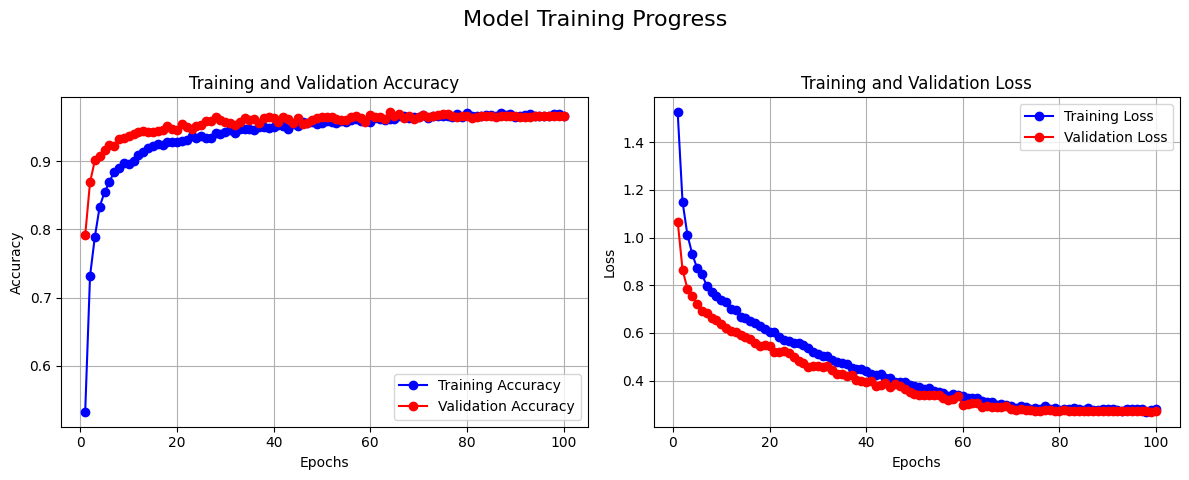

In [14]:
#Plot Training History
def plot_training_history(training_history):
    history_dict = training_history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs_completed = range(1, len(acc) + 1)

    # Plot 1: Accuracy
    plt.figure(figsize=(12, 5)) # Create a figure for the plots
    
    plt.subplot(1, 2, 1) # First subplot for accuracy
    plt.plot(epochs_completed, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_completed, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(1, 2, 2) # Second subplot for loss
    plt.plot(epochs_completed, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_completed, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle('Model Training Progress', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show() # Display plots in Jupyter Notebook

plot_training_history(history)